# DATA HARVESTER NOTEBOOK
-------------------------

The Data Harvester enables researchers with reusable workflows for automatic data extraction from a range of data sources including spatial-temporal processing into useable formats. User provided data is auto-completed with a suitable set of spatial- and temporal-aligned covariates as a ready-made dataset for machine learning and agriculture models. In addition, all requested data layer maps are automatically extracted and aligned for a specific region and time period. 

The main workflow of the Harvester is as follows: 
1) Options and user settings (e.g., data layer selections, spatial coverage, temporal constraints, i/o directory names) are defined by the user in the notebook settings menu or can be loaded with a settings yaml file (e.g., settings/settings_v0.2_saved.yaml). All settings are also saved in a yaml file for reusability.
2) The notebook imports settings and all Python modules that include functionality to download and extract data for each data source. After settings are read in, checked, and processed into valid data retrieval (API) queries, all selected data layers are sequentially downloaded and then processed into a clean dataframe table and co-registered raster maps. The entire workflow can be run either completely automatically or individually by selecting only certain process parts in the Notebook.

Additional data sources can be best added by writing the API handlers and extraction functionalities as separate Python module, which are then imported by the Notebook. Currently the following data sources are supported by the following modules:

- 'getdata_slga.py': Soil Data from Soil and Landscape Grid of Australia (SLGA)
- 'getdata_landscape': Landscape data from Soil and Landscape Grid of Australia (SLGA)
- 'getdata_silo.py': Climate Data from SILO
- 'getdata_dem.py: 'National Digital Elevation Model (DEM) 1 Second plus Slope and Apect calculation
- 'getdata_dea_nci.py: 'Digital Earth Australia's (DEA) Geoscience Earth Observations via NCI server
- 'getdata_dea.py: 'Digital Earth Australia's (DEA) Geoscience Earth Observations via Open Web Service server provided by DEA
- 'getdata_radiometric.py': Geoscience Australia National Geophysical Compilation Sub-collection Radiometrics
- 'getdata_ee.py': Google Earth Engine API integration handler

For more details. please see README and the Data Overview page.

This notebook is part of the Data Harvester project developed for the Agricultural Research Federation (AgReFed).

Copyright 2022 Sydney Informatics Hub (SIH), The University of Sydney

In [1]:
#Load general python libraries
import os
import time
from datetime import datetime
from os.path import exists
from pathlib import Path
from types import SimpleNamespace

import geopandas as gpd
import getdata_dea
import getdata_dem

# Load local modules/functions/packages
# See each python file for detailed options
import getdata_ee
import getdata_landscape
import getdata_radiometric
import getdata_silo
import getdata_slga
import matplotlib.pyplot as plt
import pandas as pd
import utils
from arc2meter import calc_arc2meter
from utils import init_logtable, update_logtable
import temporal
from widgets import harvesterwidgets as hw

## Note: library alive-progress is used in multiple modules, but is not working if dask is installed (bug in alive-progress)

## Import settings

Let's start with loading all user settings and options as specified in the settings file. For this example we provide a template file `settings/settings_v0.1_default.yaml`. You can comfortable use the default settings in this file. 
Or you may changed the file directly, or point to a new file.
Or override any of the defaults throughout this notebook.

Load in a "settings" file or use the `load_settingsfilename =''` to manually initialise.

In [2]:
# This cell is tagged with "parameters" if notebook is run with papermill command line arguments (leave blank)
load_settingsfilename = 'settings/settings_v0.6.yaml'

#For importing custom settings widgets
if load_settingsfilename == '':
    tab_nest, w_settings, names_settings, w_load = hw.gen_maintab()
    #Note: the display screen may take a couple of seconds more after loading
    time.sleep(2)
    display(tab_nest) 

In [4]:
#For recording time:
start_time = datetime.now()

if load_settingsfilename != '':
    # load settings fromm file given by command line argument
    print(f'Automatinc loading settings from {load_settingsfilename}')
    settings = hw.load_settings(load_settingsfilename)
elif w_load.value == None:
    # if no settings file selected, convert widgets inputs above to settings
    dict_settings = hw.eval_widgets(w_settings, names_settings)
    # Convert settings from dictionary to SimpleNamespace (so all settings names available as settings.xxxname)
    settings = SimpleNamespace(**dict_settings)
    # Check if output path exists, if not create it:
    os.makedirs(settings.outpath, exist_ok=True) 
    # Save settings to yaml file:
    hw.save_dict_settings(dict_settings, os.path.join(settings.outpath, 'settings_saved.yaml'))
else:
    print(f'Settings loaded from {w_load.value}')
    settings = hw.load_settings(w_load.value)
hw.print_settings(settings)


Automatinc loading settings from settings/settings_v0.6.yaml
Settings loaded:
----------------
settings.infile : /Users/seb/CTDS/Projects/AgReFed/data/Splined_Clay_Sand_OC_COV.csv
settings.outpath : ../../dataresults/
settings.colname_lng : Long
settings.colname_lat : Lat
settings.target_bbox : 
settings.target_res : 6.0
settings.date_min : 2022-10-01
settings.time_intervals : 4
settings.date_max : 2022-11-30
settings.time_buffer : 7
settings.target_sources:
   'DEA': ['landsat_barest_earth', 'ga_ls_ard_3']
   'DEM': ['DEM']
   'Landscape': ['Slope', 'Aspect', 'Relief_300m']
   'Radiometric': ['radmap2019_grid_dose_terr_awags_rad_2019', 'radmap2019_grid_dose_terr_filtered_awags_rad_2019']
   'SILO': {'max_temp': 'median', 'min_temp': 'median', 'monthly_rain': 'sum', 'daily_rain': 'mean'}
   'SLGA': {'Bulk_Density': ['0-5cm'], 'Clay': ['0-5cm']}
   'GEE': {'preprocess': {'collection': 'LANDSAT/LC09/C02/T1_L2', 'coords': None, 'date': datetime.date(2021, 1, 1), 'end_date': datetime.date(

## Setup dataset of interest

Here we are reading in the point locations for which we want to extract data. A custom bounding box for which to extract raster data can be set in the settings file. If no bounding box provided, rasters are extracted for the region given by the point location extent plus an additional padding of 0.05 deg in Lat/Long (see code below).

In [5]:
# Load in the dataset defining our location of interest as a geopandas dataframe
gdfpoints = gpd.read_file(settings.infile)

# This particular dataset contains duplicate point locations at different depths.
# We can take advantage of the Notebook environment to make small manipulations
# to pull out just the data we need, i.e:
gdfpoints=gdfpoints.loc[gdfpoints['depth'] == "0-5 cm"]

# Assing the data to well-named variables
longs = gdfpoints[settings.colname_lng].astype(float)
lats = gdfpoints[settings.colname_lat].astype(float)

In [7]:
# Check the data looks reasonable
gdfpoints

,field_1,Lat,Long,Easting,Northing,depth,geometry
0,0,-30.264663,149.85268,774457.572546495,6648441.94497259,0-5 cm,None
5,5,-30.265302,149.884838,777550.996253435,6648292.91822913,0-5 cm,None
9,9,-30.265302,149.884838,777550.996253435,6648292.91822913,0-5 cm,None
14,14,-30.278542,149.838791,773082.294868699,6646936.5315563,0-5 cm,None
19,19,-30.275437,149.830843,772325.998393026,6647299.91001948,0-5 cm,None
...,...,...,...,...,...,...,...
301,301,-30.268262,149.87615,776706.461982309,6647985.91473127,0-5 cm,None
303,303,-30.257031,149.880983,777203.209597229,6649219.44050086,0-5 cm,None
305,305,-30.258505,149.891118,778174.632122178,6649031.2174191,0-5 cm,None
307,307,-30.261989,149.884329,777511.33275707,6648661.51497715,0-5 cm,None


In [7]:
# Use padding area of interest +/- 0.05 deg if no bbox provided. 
if (settings.target_bbox == None) | (settings.target_bbox == 'None') | (settings.target_bbox == ''):
    settings.target_bbox = (min(longs)-0.05,min(lats)-0.05,max(longs)+0.05,max(lats)+0.05)
print(f'Info: Selected bounding box: {settings.target_bbox}')

# Estimate resolution in meters:
lat_center = (settings.target_bbox[1]+settings.target_bbox[3])/2
xres_meters, yres_meters = calc_arc2meter(settings.target_res, lat_center)
print(f'Info: {settings.target_res} arcsec resolution corresponds to {xres_meters:.1f}m x {yres_meters:.1f}m in x,y direction respectively (at Latitude: {lat_center:.2f}).')

Info: Selected bounding box: (149.769345, -30.335861, 149.949173, -30.206271)
Info: 6.0 arcsec resolution corresponds to 160.2m x 185.2m in x,y direction respectively (at Latitude: -30.27).


## Download and process data from API sources

From here we automatically download and process sequentially a range of data sources as specified in the settings file (see next subsections: SLGA, SILO, DEA, DEM). Note that you may retrieve info and parameter input options for any function easily by running a function/method with a preceeding '?', e.g:
```
?getdata_slga.get_slga_layers
?utils
```

In [8]:
# Initiate a dataframe for logging all data output names and layer titles.
# Note that the log table is later updated with update_logtable(), 
# which also instantly saves a copy of the table of the current status.
df_log = init_logtable()

### SLGA Download

Here we download all requested data layers from the Soil and Landscape Grid of Australia (SLGA) for the given bounding box. Note that for this example we select the top soil (0 - 5cm) only. Optionally other layers and depths including confidence intervals can be extracted as well; for more details and options see getdata_slga.py.

In [9]:
# We can set the input options for each function call, and additional parameters may be set
# too. Check the documentation of each function for full list of options.
depth_min, depth_max = getdata_slga.identifier2depthbounds(list(settings.target_sources['SLGA'].values())[0])
slga_layernames = list(settings.target_sources['SLGA'].keys())
fnames_out_slga = getdata_slga.get_slga_layers(
    slga_layernames, 
    settings.target_bbox, 
    settings.outpath, 
    depth_min = depth_min, 
    depth_max= depth_max, 
    get_ci = True)

⚑ SLGA_Bulk_Density_0-5cm.tif already exists, skipping download
⚑ SLGA_Bulk_Density_0-5cm_5percentile.tif already exists, skipping download
⚑ SLGA_Bulk_Density_0-5cm_95percentile.tif already exists, skipping download
⚑ SLGA_Clay_0-5cm.tif already exists, skipping download
⚑ SLGA_Clay_0-5cm_5percentile.tif already exists, skipping download
⚑ SLGA_Clay_0-5cm_95percentile.tif already exists, skipping download


In [10]:
# Add download info to log dataframe
df_log = update_logtable(df_log, fnames_out_slga, slga_layernames, 'SLGA', settings, layertitles = [], loginfos = 'downloaded')
df_log

,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,../../dataresults/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,../../dataresults/SLGA_Clay_0-5cm.tif,downloaded


### SILO Download

Here we download climate data layers from SILO and extract raster for the given bounding box and year.
For more details see getdata_silo.py

In [11]:
# Each data-source must be handled differently (as the data is stored in different ways)
# Here we must get each layer, one by one. The simplest way is to loop through them.
# Get data for each layer
outpath = settings.outpath+'_silo'
silo_layernames = list(settings.target_sources['SILO'].keys())
# run the download
fnames_out_silo = getdata_silo.get_SILO_layers(
    silo_layernames, 
    settings.date_min, 
    settings.date_max,
    outpath, 
    bbox = settings.target_bbox, 
    format_out = 'tif')

# Add download info to log dataframe
# TBD need to be tested for multiple years and not only one
if len(fnames_out_silo) > len(silo_layernames):
    # TBD Temporary solution for multiple years:
    nyears = int(len(fnames_out_silo)/len(silo_layernames))
    silo_layernames = silo_layernames * nyears
df_log = update_logtable(df_log, fnames_out_silo, silo_layernames, 'SILO', settings, layertitles = [], loginfos = 'downloaded')
df_log

⚑ max_temp for 2022 already exists, skipping download
⚑ min_temp for 2022 already exists, skipping download
⚑ monthly_rain for 2022 already exists, skipping download
⚑ daily_rain for 2022 already exists, skipping download


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,../../dataresults/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,../../dataresults/SLGA_Clay_0-5cm.tif,downloaded
2,max_temp,median,SILO,max_temp_median,../../dataresults/_silo/silo_max_temp_2022-10-...,downloaded
3,min_temp,median,SILO,min_temp_median,../../dataresults/_silo/silo_min_temp_2022-10-...,downloaded
4,monthly_rain,sum,SILO,monthly_rain_sum,../../dataresults/_silo/silo_monthly_rain_2022...,downloaded
5,daily_rain,mean,SILO,daily_rain_mean,../../dataresults/_silo/silo_daily_rain_2022-1...,downloaded


#### SILO Processing

This is an example for further processing of the extracted SILO data. Here we are interested in generating a mean temperature raster given the already extracted min and max temperature rasters.

In [12]:
#Here we want to immediately perform some data processing on the SILO layers.

# TBD: THIS IS NOT WORKING YET. NEED TO TAKE AGGREGATION FROM SETTINGS AND NOT JUST HARDCODED EXAMPLE BELOW

# Sub select whatever files we want to aggregate, from the log file
file_list = df_log[df_log['layername'].isin(['min_temp','max_temp'])].filename_out.to_list()

if len(file_list) == 2:
    # Both have a recommendation of running mean, so lets set that
    agg = ['mean']

    # Set an output filename if wanted
    outfile = settings.outpath+'silo_temp_ag'

    # And run the processing
    outfname_agg = utils.aggregate_rasters(
        file_list=file_list,
        outfile=outfile, 
        data_dir=None,
        agg=agg)
        
    # Add processed info to log dataframe
    df_log = update_logtable(df_log, 
                             [outfname_agg[0]], 
                             ['mean_temp'], 
                             'SILO', 
                             settings, 
                             layertitles = ['mean_temp'], 
                             agfunctions = ['mean'], 
                             loginfos = 'processed')
    df_log

Finding ['mean']  out of possible ['mean', 'median', 'sum', 'perc95', 'perc5']
mean of filelist saved in:  ../../dataresults/silo_temp_ag_mean.tif


### DEA Download

Here we download satellite data from Digital Earth Australia (DEA) within the given bounding box and for all available image capture dates that are available within the specified year(s). For more details see getdata_dea.py or getdata_dea_nci
.py

In [15]:
dea_layernames = settings.target_sources['DEA']

# These are multiple files, so we put them in a subdirectory to make subsequent processing easier.
outpath_dea = os.path.join(settings.outpath,'mvp_dea')


outfnames = getdata_dea.get_dea_layers_daterange(
   dea_layernames, 
   settings.date_min,
   settings.date_max,
   settings.target_bbox, 
   settings.target_res, 
   outpath_dea, 
   crs = 'EPSG:4326', 
   format_out = 'GeoTIFF')


⚑ landsat_barest_earth.tif already exists, skipping download
⚑ ga_ls_ard_3.tif already exists, skipping download
⚑ ga_ls_ard_3.tif already exists, skipping download
⚑ ga_ls_ard_3.tif already exists, skipping download
⚑ ga_ls_ard_3.tif already exists, skipping download
⚑ ga_ls_ard_3.tif already exists, skipping download
⚑ ga_ls_ard_3.tif already exists, skipping download
⚑ ga_ls_ard_3.tif already exists, skipping download
⚑ ga_ls_ard_3.tif already exists, skipping download
⚑ ga_ls_ard_3.tif already exists, skipping download
⚑ ga_ls_ard_3.tif already exists, skipping download
⚑ ga_ls_ard_3.tif already exists, skipping download
⚑ ga_ls_ard_3.tif already exists, skipping download
⚑ ga_ls_ard_3.tif already exists, skipping download
⚑ ga_ls_ard_3.tif already exists, skipping download
⚑ ga_ls_ard_3.tif already exists, skipping download
⚑ ga_ls_ard_3.tif already exists, skipping download
⚑ ga_ls_ard_3.tif already exists, skipping download
⚑ ga_ls_ard_3.tif already exists, skipping download
⚑ g

#### DEA Processing

This aggregates all images for the given year(s) and gnerates a combined image, here for example for the mean and 5th and 95th percentile each.

In [13]:
outfnames

['../../dataresults/mvp_dea/landsat_barest_earth.tif',
 '../../dataresults/mvp_dea/ga_ls_ard_3_2022-9-30.tif',
 '../../dataresults/mvp_dea/ga_ls_ard_3_2022-10-1.tif',
 '../../dataresults/mvp_dea/ga_ls_ard_3_2022-10-2.tif',
 '../../dataresults/mvp_dea/ga_ls_ard_3_2022-10-3.tif',
 '../../dataresults/mvp_dea/ga_ls_ard_3_2022-10-4.tif',
 '../../dataresults/mvp_dea/ga_ls_ard_3_2022-10-5.tif',
 '../../dataresults/mvp_dea/ga_ls_ard_3_2022-10-6.tif',
 '../../dataresults/mvp_dea/ga_ls_ard_3_2022-10-7.tif',
 '../../dataresults/mvp_dea/ga_ls_ard_3_2022-10-8.tif',
 '../../dataresults/mvp_dea/ga_ls_ard_3_2022-10-9.tif',
 '../../dataresults/mvp_dea/ga_ls_ard_3_2022-10-10.tif',
 '../../dataresults/mvp_dea/ga_ls_ard_3_2022-10-11.tif',
 '../../dataresults/mvp_dea/ga_ls_ard_3_2022-10-12.tif',
 '../../dataresults/mvp_dea/ga_ls_ard_3_2022-10-13.tif',
 '../../dataresults/mvp_dea/ga_ls_ard_3_2022-10-14.tif',
 '../../dataresults/mvp_dea/ga_ls_ard_3_2022-10-15.tif',
 '../../dataresults/mvp_dea/ga_ls_ard_3_202

In [14]:
# TBD: THIS CODE BELOW IS WRONG FOR MULTIPLE LAYERS. THE TEMPORAL AGGREGATION NEED TO DISTINGUISH BETWEEN 
# DIFFERENT LAYERS, 
# CURRENTLY ASSUMES ALL FILES IN OUTPATH ARE FORM SAME LAYER
# Also need to be replace with new temporal ag function (with temporal buffer and temp intervals)

# Process DEA data over time aggregates
outfname_list, channel_list, agg_list = utils.aggregate_multiband(
    file_list = outfnames[1:],
    outfile = settings.outpath+"mvp_dea",
    agg = ['mean','perc95','perc5'],
    data_dir = None)

Finding ['mean', 'perc95', 'perc5']  out of possible ['mean', 'median', 'sum', 'perc95', 'perc5']
mean of filelist saved in:  ../../dataresults/mvp_dea_mean_channel_nbart_blue.tif
perc95 of filelist saved in:  ../../dataresults/mvp_dea_perc95_channel_nbart_blue.tif
perc5 of filelist saved in:  ../../dataresults/mvp_dea_perc5_channel_nbart_blue.tif
mean of filelist saved in:  ../../dataresults/mvp_dea_mean_channel_nbart_green.tif
perc95 of filelist saved in:  ../../dataresults/mvp_dea_perc95_channel_nbart_green.tif
perc5 of filelist saved in:  ../../dataresults/mvp_dea_perc5_channel_nbart_green.tif
mean of filelist saved in:  ../../dataresults/mvp_dea_mean_channel_nbart_red.tif
perc95 of filelist saved in:  ../../dataresults/mvp_dea_perc95_channel_nbart_red.tif
perc5 of filelist saved in:  ../../dataresults/mvp_dea_perc5_channel_nbart_red.tif
mean of filelist saved in:  ../../dataresults/mvp_dea_mean_channel_nbart_nir.tif
perc95 of filelist saved in:  ../../dataresults/mvp_dea_perc95_ch

In [17]:
# Add extracted data info to log table
layernames = []
for layername in dea_layernames:
        layernames += [layername + '_channel' + channel_list[i] for i in range(len(channel_list))]
df_log = update_logtable(df_log, outfname_list, layernames, 'DEA', settings, agfunctions = agg_list, loginfos = 'processed')
#print(df_log.layertitle)
df_log

Error: Number of filenames does not match number of layernames. Dataframe not updated.


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,../../dataresults/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,../../dataresults/SLGA_Clay_0-5cm.tif,downloaded
2,max_temp,median,SILO,max_temp_median,../../dataresults/_silo/silo_max_temp_2022-10-...,downloaded
3,min_temp,median,SILO,min_temp_median,../../dataresults/_silo/silo_min_temp_2022-10-...,downloaded
4,monthly_rain,sum,SILO,monthly_rain_sum,../../dataresults/_silo/silo_monthly_rain_2022...,downloaded
5,daily_rain,mean,SILO,daily_rain_mean,../../dataresults/_silo/silo_daily_rain_2022-1...,downloaded
6,mean_temp,mean,SILO,mean_temp,../../dataresults/silo_temp_ag_mean.tif,processed


### DEM Download

Here we download and extract the National Digital Elevation Model (DEM), and also generate slope and aspect rasters from the extracted DEM. 
For more details see getdata_dem.py

In [16]:
outpath = os.path.join(settings.outpath, "mvp_dem")
dem_layernames = settings.target_sources['DEM']
outfnames = getdata_dem.get_dem_layers(dem_layernames, outpath, settings.target_bbox, settings.target_res)

# Add extracted data to log dataframe
df_log = update_logtable(
    df_log, outfnames, 
    dem_layernames, 
    'DEM', 
    settings, 
    layertitles = dem_layernames,
    loginfos = 'downloaded')
df_log

⊙ Retrieving coverage from WCS server 3.9s                                                                     
⊙ Downloading DEM_SRTM_1_Second_Hydro_Enforced_2022_12_13.tif 1.2s                                             


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,../../dataresults/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,../../dataresults/SLGA_Clay_0-5cm.tif,downloaded
2,max_temp,median,SILO,max_temp_median,../../dataresults/_silo/silo_max_temp_2022-10-...,downloaded
3,min_temp,median,SILO,min_temp_median,../../dataresults/_silo/silo_min_temp_2022-10-...,downloaded
4,monthly_rain,sum,SILO,monthly_rain_sum,../../dataresults/_silo/silo_monthly_rain_2022...,downloaded
5,daily_rain,mean,SILO,daily_rain_mean,../../dataresults/_silo/silo_daily_rain_2022-1...,downloaded
6,mean_temp,mean,SILO,mean_temp,../../dataresults/silo_temp_ag_mean.tif,processed
7,DEM,None,DEM,DEM,../../dataresults/mvp_dem/DEM_SRTM_1_Second_Hy...,downloaded


### Landscape

Download landscape data from Soil and Landscape Grid of Australia (SLGA).

In [19]:
# Download landscape data
layernames = settings.target_sources['Landscape']
layertitles = ['Landscape_' + layername for layername in layernames]

outfnames = getdata_landscape.get_landscape_layers(
    layernames, 
    settings.target_bbox, 
    settings.outpath, 
    resolution = settings.target_res)

# Add extracted data to log dataframe
df_log = update_logtable(
    df_log, outfnames, 
    layernames, 
    'Landscape', 
    settings, 
    layertitles = layertitles,
    loginfos = 'downloaded')
df_log


⚑ Landscape_Slope.tif already exists, skipping download
⚑ Landscape_Aspect.tif already exists, skipping download
⚑ Landscape_Relief_300m.tif already exists, skipping download


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,../../dataresults/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,../../dataresults/SLGA_Clay_0-5cm.tif,downloaded
2,max_temp,median,SILO,max_temp_median,../../dataresults/_silo/silo_max_temp_2022-10-...,downloaded
3,min_temp,median,SILO,min_temp_median,../../dataresults/_silo/silo_min_temp_2022-10-...,downloaded
4,monthly_rain,sum,SILO,monthly_rain_sum,../../dataresults/_silo/silo_monthly_rain_2022...,downloaded
5,daily_rain,mean,SILO,daily_rain_mean,../../dataresults/_silo/silo_daily_rain_2022-1...,downloaded
6,mean_temp,mean,SILO,mean_temp,../../dataresults/silo_temp_ag_mean.tif,processed
7,DEM,None,DEM,DEM,../../dataresults/mvp_dem/DEM_SRTM_1_Second_Hy...,downloaded
8,Slope,None,Landscape,Landscape_Slope,../../dataresults/Landscape_Slope.tif,downloaded
9,Aspect,None,Landscape,Landscape_Aspect,../../dataresults/Landscape_Aspect.tif,downloaded


### Radiometrics

Download maps of Geoscience Australia National Geophysical Compilation Sub-collection Radiometrics

In [21]:
# Download radiometrics
layernames = settings.target_sources['Radiometric']

outfnames = getdata_radiometric.get_radiometric_layers(
    settings.outpath, 
    layernames, 
    bbox = settings.target_bbox, 
    resolution=settings.target_res)

 # Add extracted data to log dataframe
df_log = update_logtable(
    df_log, outfnames, 
    layernames, 
    'Radiometric', 
    settings, 
    layertitles = layernames,
    loginfos = 'downloaded')
df_log

⊙ Downloading radmap2019_grid_dose_terr_awags_rad_2019 3.1s                                                             
⊙ Downloading radmap2019_grid_dose_terr_filtered_awags_rad_2019 2.1s                                                    
Error: ../../dataresults/radiometric_radmap2019_grid_dose_terr_awags_rad_2019.tif exists in df_log! Dataframe not updated.


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,../../dataresults/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,../../dataresults/SLGA_Clay_0-5cm.tif,downloaded
2,max_temp,median,SILO,max_temp_median,../../dataresults/_silo/silo_max_temp_2022-10-...,downloaded
3,min_temp,median,SILO,min_temp_median,../../dataresults/_silo/silo_min_temp_2022-10-...,downloaded
4,monthly_rain,sum,SILO,monthly_rain_sum,../../dataresults/_silo/silo_monthly_rain_2022...,downloaded
5,daily_rain,mean,SILO,daily_rain_mean,../../dataresults/_silo/silo_daily_rain_2022-1...,downloaded
6,mean_temp,mean,SILO,mean_temp,../../dataresults/silo_temp_ag_mean.tif,processed
7,DEM,None,DEM,DEM,../../dataresults/mvp_dem/DEM_SRTM_1_Second_Hy...,downloaded
8,Slope,None,Landscape,Landscape_Slope,../../dataresults/Landscape_Slope.tif,downloaded
9,Aspect,None,Landscape,Landscape_Aspect,../../dataresults/Landscape_Aspect.tif,downloaded


## Temporal processing
Many datasets have time varying dependecny that we may wish to explore different aggregation statitics at different time buffers for speciifc time periods.

In [22]:
# Example one. Combine multiple year data sets
file_list = [
    '../data/mvp_daily_rain_silo/daily_rain_2017_cropped.tif',
    '../data/mvp_daily_rain_silo/daily_rain_2018_cropped.tif'
]

# Combine the rasters using the approriate 'channel' and 'attribute'
xdr = temporal.combine_rasters_temporal(
    file_list, channel_name='band',attribute_name='long_name')

# Now create new datasets based on some temporal buffer (period) and aggregation methods.
outfname_list, agg_list = temporal.aggregate_temporal(
    xdr,period='monthly',agg=['mean','sum'],outfile=settings.outpath+'temporal_agg')

Concatenating band and long_name over ['../data/mvp_daily_rain_silo/daily_rain_2017_cropped.tif', '../data/mvp_daily_rain_silo/daily_rain_2018_cropped.tif']


RasterioIOError: ../data/mvp_daily_rain_silo/daily_rain_2017_cropped.tif: No such file or directory

In [20]:
layernames = ['mvp_daily_rain_silo_'+f.split('.')[-2].split('/')[-1] for f in outfname_list]
# temporal_settings.target_sources['SILO'] = agg
# agfunctions = [f.split('_')[2] for f in outfname_list]


df_log = update_logtable(
    df_log, 
    outfname_list, 
    layernames, 
    'SILO', 
    settings, 
    agfunctions = agg_list,
    loginfos = 'processed')

## Google Earth Engine

To connect to Google Earth Engine, you must already have access to the Google
Earth Engine API. You can request for access [by clicking
here](https://earthengine.google.com/signup/). Once you are authorised, connect
to the API using `initialise()`. A web browser may be invoked to complete the
process.

In [23]:
# Connect to the Google Earth Engine API
getdata_ee.initialise()

⊙ Initialising Earth Engine... 3.2s                                                                                     
✔ Earth Engine authenticated


### Collect and preprocess Earth Engine Data

Use `collect()` to define the data object and `preprocess()` to perform server-side
data processing which includes cloud and shadow masking, image reduction and
calculation of spectral indices.

In [24]:
gee = settings.target_sources["GEE"]

# Define the collection, area of interest and date range
img = getdata_ee.collect(collection=gee['preprocess']['collection'],
              coords=settings.target_bbox,
              date=gee["preprocess"]["date"], 
              end_date = gee["preprocess"]["end_date"])

# Perform cloud maskng, reduction, and calculate one or more spectral indices
img.preprocess(mask_clouds=gee["preprocess"]["mask_clouds"], 
               reduce=gee["preprocess"]["reduce"], 
               spectral=gee["preprocess"]["spectral"])

ℹ Running preprocess()
⊙ Applying scale, offset and cloud masks... 1.0s                                                                        
⊙ Computing spectral index: NDVI 1.5s                                                                                   
⊙ Reducing image pixels by median 0.0s                                                                                  
✔ Google Earth Engine preprocessing complete


### Download

Download the data using `download()` and add to `df_log`:

In [25]:
# Downoad data
img.download(bands=gee["download"]["bands"],
             scale=gee["download"]["scale"],
             outpath=settings.outpath,
             out_format=gee["download"]["format"])


# Add to log dataframe
outfnames = [settings.outpath + img.filenames]
layernames = [Path(img.filenames).resolve().stem]

df_log = update_logtable(
    df_log,
    outfnames,
    layernames,
    "GEE",
    settings,
    layertitles=[],
    agfunctions=img.reduce,
    loginfos="downloaded",
    )

df_log # preview

ℹ Running download()
ℹ Band(s) selected: NDVI
⊙ Downloading ee_LAN_20210101_20211231_NDVI_median_100m.tif ▃▅▇ 2s ▄▆█ 3s 

on 0: CPLE_NotSupported in 'None' is an unexpected value for PHOTOMETRIC creation option of type string-select.


⊙ Downloading ee_LAN_20210101_20211231_NDVI_median_100m.tif ▅▇▇ 3s 

on 0: CPLE_IllegalArg in ../../dataresults/ee_LAN_20210101_20211231_NDVI_median_100m.tif: PHOTOMETRIC=None value not recognised, ignoring.  Set the Photometric Interpretation as MINISBLACK.


⊙ Downloading ee_LAN_20210101_20211231_NDVI_median_100m.tif ▂▂▄ 6s                                                      

on 0: There is no STAC entry for: None


⊙ Downloading ee_LAN_20210101_20211231_NDVI_median_100m.tif 6.4s                                                        
✔ Google Earth Engine download(s) complete


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,../../dataresults/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,../../dataresults/SLGA_Clay_0-5cm.tif,downloaded
2,max_temp,median,SILO,max_temp_median,../../dataresults/_silo/silo_max_temp_2022-10-...,downloaded
3,min_temp,median,SILO,min_temp_median,../../dataresults/_silo/silo_min_temp_2022-10-...,downloaded
4,monthly_rain,sum,SILO,monthly_rain_sum,../../dataresults/_silo/silo_monthly_rain_2022...,downloaded
5,mean_temp,mean,SILO,mean_temp,../../dataresults/silo_temp_ag_mean.tif,processed
6,DEM,None,DEM,DEM,../../dataresults/mvp_dem/DEM_SRTM_1_Second_Hy...,downloaded
7,Slope,None,Landscape,Landscape_Slope,../../dataresults/Landscape_Slope.tif,downloaded
8,Aspect,None,Landscape,Landscape_Aspect,../../dataresults/Landscape_Aspect.tif,downloaded
9,Relief_300m,None,Landscape,Landscape_Relief_300m,../../dataresults/Landscape_Relief_300m.tif,downloaded


## Save the final log or start from here to re-load it in.
We have now completed the data download section. You may add additional downlods and processing steps to your log file.

In [24]:
# Save out (or load in) the log file.
logfile = settings.outpath+'log.csv'
if exists(logfile):
    print(logfile, "exists! Do you want to read it in?\n")
    user_input = input("(y)es / (n)o / (a)bort ? Ansering 'no' will overwrite the current file.\n")
    if user_input=='y':
        df_log = pd.read_csv(settings.outpath+'log.csv')
    elif user_input =='n': 
        df_log.to_csv(settings.outpath+'log.csv',index=False)
        print(logfile, "saved!")
    else:
        print("Cancelling read/write for log file.\nFigure out what you want to do and please try again.")
else:
    print("No log file found. Saving to", settings.outpath+'log.csv')
    df_log.to_csv(settings.outpath+'log.csv',index=False)

df_log

../../dataresults/log.csv exists! Do you want to read it in?

(y)es / (n)o / (a)bort ? Ansering 'no' will overwrite the current file.
n
../../dataresults/log.csv saved!


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,../../dataresults/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,../../dataresults/SLGA_Clay_0-5cm.tif,downloaded
2,max_temp,Median,SILO,max_temp_Median,../../dataresults/mvp_max_temp_silo/max_temp_2...,downloaded
3,min_temp,Median,SILO,min_temp_Median,../../dataresults/mvp_min_temp_silo/min_temp_2...,downloaded
4,monthly_rain,Total,SILO,monthly_rain_Total,../../dataresults/mvp_monthly_rain_silo/monthl...,downloaded
5,mean_temp,mean,SILO,mean_temp,../../dataresults/silo_temp_2019_ag_mean.tif,processed
6,landsat_barest_earth_channel0,mean,DEA,landsat_barest_earth_channel0_mean,../../dataresults/mvp_dea_mean_channel_red.tif,processed
7,landsat_barest_earth_channel0,perc95,DEA,landsat_barest_earth_channel0_perc95,../../dataresults/mvp_dea_perc95_channel_red.tif,processed
8,landsat_barest_earth_channel0,perc5,DEA,landsat_barest_earth_channel0_perc5,../../dataresults/mvp_dea_perc5_channel_red.tif,processed
9,landsat_barest_earth_channel1,mean,DEA,landsat_barest_earth_channel1_mean,../../dataresults/mvp_dea_mean_channel_green.tif,processed


## Points extraction from downloaded/processed data

By default point values of all processed layers in df_log are extracted given by the input locations. However, you can select also only certain layers (see in code). 

In [25]:
# Select all processed data
df_sel = df_log.copy()

# or select only the rasters of interest, for example:
"""
df_sel = df_log[df_log['layername'].isin(['DEM','Slope',
'landsat8_nbart_16day_channel0', 
'Organic_Carbon','Depth_of_Soil',
'mean_temp','monthly_rain'])]
"""

rasters= df_sel['filename_out'].values.tolist()
titles = df_sel['layertitle'].values.tolist()
    
# Extract datatable from rasters given input coordinates
gdf = utils.raster_query(longs,lats,rasters,titles)

⊙ • SLGA_Bulk_Density_0-5cm | pixel size: (156, 216) 0.3s                                                      
⊙ • SLGA_Clay_0-5cm | pixel size: (156, 216) 0.0s                                                              
⊙ • max_temp_2021_cropped | pixel size: (2, 3) 0.0s                                                            
⊙ • min_temp_2021_cropped | pixel size: (2, 3) 0.0s                                                            
⊙ • monthly_rain_2021_cropped | pixel size: (2, 3) 0.0s                                                        
⊙ • silo_temp_2019_ag_mean | pixel size: (2, 3) 0.0s                                                           
⊙ • mvp_dea_mean_channel_red | pixel size: (77, 107) 0.0s                                                      
⊙ • mvp_dea_perc95_channel_red | pixel size: (77, 107) 0.0s                                                    
⊙ • mvp_dea_perc5_channel_red | pixel size: (77, 107) 0.0s                                              

### Inspect result dataframe

In [26]:
# Inspect either entire generated dataframe with 
# gdf
# or only the first rows
gdf.head()

,Longitude,Latitude,geometry,Bulk_Density_0-5cm,Clay_0-5cm,max_temp_Median,min_temp_Median,monthly_rain_Total,mean_temp,landsat_barest_earth_channel0_mean,...,mvp_daily_rain_silo_temporal_agg_sum_04_sum,mvp_daily_rain_silo_temporal_agg_sum_05_sum,mvp_daily_rain_silo_temporal_agg_sum_06_sum,mvp_daily_rain_silo_temporal_agg_sum_07_sum,mvp_daily_rain_silo_temporal_agg_sum_08_sum,mvp_daily_rain_silo_temporal_agg_sum_09_sum,mvp_daily_rain_silo_temporal_agg_sum_10_sum,mvp_daily_rain_silo_temporal_agg_sum_11_sum,mvp_daily_rain_silo_temporal_agg_sum_12_sum,ee_LAN_20210101_20211231_NDVISRB2SRB3SRB4_median_100m_median
0,149.852680,-30.264663,POINT (149.85268 -30.26466),1.368779,27.214527,30.0,20.200001,47.000000,18.031786,1059.0,...,25.499023,36.099365,43.499512,17.199463,53.000000,12.099609,163.298584,134.699463,81.398682,0.692533
5,149.884838,-30.265302,POINT (149.88484 -30.26530),1.362662,31.956041,30.0,20.000000,47.399902,17.897812,1082.0,...,25.798828,45.398682,44.898926,17.799072,51.699463,12.599365,158.898193,129.598389,78.098633,0.221940
9,149.884838,-30.265302,POINT (149.88484 -30.26530),1.362662,31.956041,30.0,20.000000,47.399902,17.897812,1082.0,...,25.798828,45.398682,44.898926,17.799072,51.699463,12.599365,158.898193,129.598389,78.098633,0.221940
14,149.838791,-30.278542,POINT (149.83879 -30.27854),1.360451,32.675858,29.9,20.300001,35.899902,18.145342,1092.0,...,29.599365,31.399170,45.899170,19.099365,52.799561,13.099365,152.198730,120.499512,90.899170,0.563295
19,149.830843,-30.275437,POINT (149.83084 -30.27544),1.334362,35.097813,29.9,20.300001,35.899902,18.145342,1160.0,...,29.599365,31.399170,45.899170,19.099365,52.799561,13.099365,152.198730,120.499512,90.899170,0.737653


In [27]:
# Get some general info about result table:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 82 entries, 0 to 309
Data columns (total 58 columns):
 #   Column                                                        Non-Null Count  Dtype   
---  ------                                                        --------------  -----   
 0   Longitude                                                     82 non-null     float64 
 1   Latitude                                                      82 non-null     float64 
 2   geometry                                                      82 non-null     geometry
 3   Bulk_Density_0-5cm                                            82 non-null     float32 
 4   Clay_0-5cm                                                    82 non-null     float32 
 5   max_temp_Median                                               82 non-null     float32 
 6   min_temp_Median                                               82 non-null     float32 
 7   monthly_rain_Total                                     

### Save the results table

Finally, the result dataframe table is saved as a csv file, which can be used now to do some awesome ML.
In addition the results are also saved as a geo-spatial referenced geopackage (.gpkg), which can be used again as input for further analysis or to inspect and overlay data on other layers and basemaps. The geopackage is a standard georeferenced file format and can be opened with any geo-spatial package or interactive software (e.g., QGIS, Esri ArcGIS). 

In [28]:
# Save the results table to a csv 
gdf.to_csv(os.path.join(settings.outpath, "results.csv"), index = True, mode='w')

# Save also as geopackage
gdf.to_file(os.path.join(settings.outpath, "results.gpkg"), driver="GPKG")
# Note: The deprecated warning below is a bug in geopandas and will be fixed in their bext version.

### Overview plot of all processed rasters 

This provides a quick overview to inspect all processed data layers with an overlay of the requested location points.
  

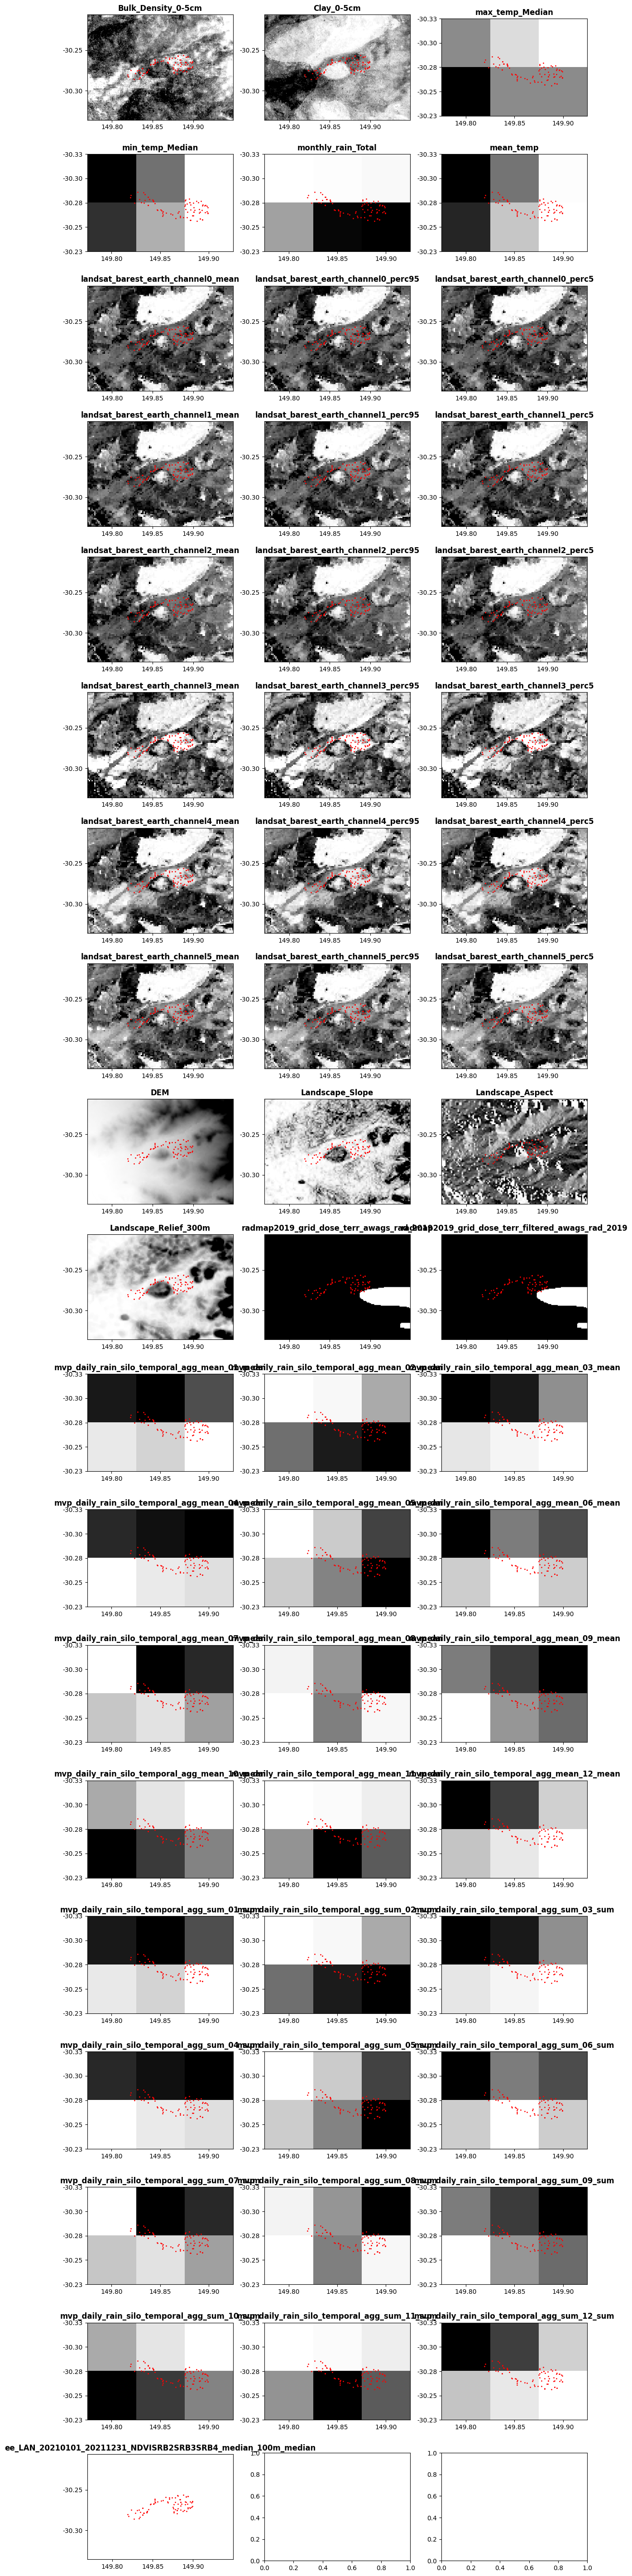

In [29]:
# Plot one of that datasets with the points on top
utils.plot_rasters(rasters,longs,lats,titles)

In [30]:
# print total time (only needed for testing if notebook kernel runs all at once):
print('FINISHED')
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

FINISHED
Duration: 0:02:32.174604
